# Forecasting Columbia River Hydropower Generation Using XGBoost

### **What is XGBoost?**
**XGBoost (Extreme Gradient Boosting)** is a powerful **machine learning algorithm** that excels in predicting future values by learning patterns from historical data. It is widely used in forecasting problems because of its ability to handle complex relationships, nonlinearity, and missing data efficiently.

In this notebook, we use **XGBoost** to predict **Columbia river hydropower generation** from **observed discharge levels at The Dalles, Oregon**. The goal is to leverage past trends in discharge to make **accurate and reliable forecasts** of future power generation.

### **Why not use traditional statistical methods?**
As discussed in other notebooks, traditional statistical methods like **Linear Regression and Vector Autoregression (VAR)** have limitations when dealing with **time-dependent, nonlinear, and highly volatile data**.
- **Linear Regression** is too simple for time series and assumes a fixed relationship betweem discharge and generation. It only predicts one variable at a time and requires **future discharge values** to predict future generation.
- **VAR (Vector Autoregression)** struggles with volatility and fails to capture nonlinear dependencies or irregular fluctuations. As seen in earlier plots, VAR-generated forecasts tend to be too smooth, making them less useful for highly fluctuating data.

### **Why XGBoost is the better choice for this problem**
- Unlike traditional statistical methods, XGBoost can learn complex and nonlinear relationships in the data.  
- Just like VAR, we can feed lagged discharge values as input to predict future hydropower generation, but with more flexibility and better performance.  
- Performs well with high volatility by learning short-term variations and adapts to sudden changes

In this notebook, we will:  
- Train an XGBoost model using lagged discharge values and seasonality as input features.  
- Visualize predictions vs. actual values to see how well XGBoost performs.
- Evaluate model accuracy and compare it with traditional methods.
- Predict future hydropower generation based on observed patterns.

In [1]:
# Import required libraries
import pandas as pd
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import numpy as np

In [2]:
# Define file paths for hourly data
generation_data_file_path = "../training_data/columbia_hydro_generation_data_H.csv"
discharge_data_file_path = "../training_data/uscs_dalles_discharge_data_H.csv"

# Loading and merging the datasets
df_generation = pd.read_csv(generation_data_file_path)
df_discharge = pd.read_csv(discharge_data_file_path)
df = df_generation.merge(df_discharge, on="Datetime", how="inner")
df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")
df.set_index(['Datetime'], inplace=True)
df.head(5)

,Total_Hydro_Generation_MW,Total_Hydro_Generation_MWh,Scaling_Ratio,Columbia_Projects_Hydro_Generation_MW,Columbia_Projects_Hydro_Generation_MWh,Discharge_CFS
Datetime,,,,,,
2023-01-01 00:00:00,5316.4,5316.5,0.9754,5185.6,5185.7,101625.0
2023-01-01 01:00:00,5261.8,5261.8,0.9754,5132.4,5132.4,103500.0
2023-01-01 02:00:00,5154.0,5153.8,0.9754,5027.2,5027.0,99375.0
2023-01-01 03:00:00,5147.5,5147.6,0.9754,5020.9,5021.0,101200.0
2023-01-01 04:00:00,5170.3,5170.1,0.9754,5043.1,5042.9,97325.0


## **Columbia River Hydropower Generation vs Discharge at The Dalles - Long Term**

This plot visualizes the relationship between **Columbia River Hydropower Generation (MW)** and **Discharge at The Dalles (CFS)** over time, spanning from **Jan 2023 to Feb 2025**.

---

### **Observations: How Generation is Dependent on Discharge & Seasonality**
- #### **Correlation Between Discharge and Generation**
  - Whenever discharge (CFS) increases, hydropower generation (MW) also increases.
  - This confirms that higher river flow contributes to greater electricity production, as more water passing through dams generates more mechanical energy.

- #### **Seasonal Trend Possibilities**
  - **Summer Surge (around May-August):**  
    - Higher energy demand, e.g., air conditioning (AC) in summer further increases power generation.
    - Snowmelt runoff from upstream regions, leading to higher river flow.

  - **Mid-to-Late Winter Surge (around December-February):**  
    - Power generation increases again due to increased electricity demand for heating.
    - Higher river flow from precipitation contributes to more hydropower production.
  
  - **Spring and Fall Decline (around March-May and September-November):**  
    - Less precipitation and energy demand lead to lower water flow.

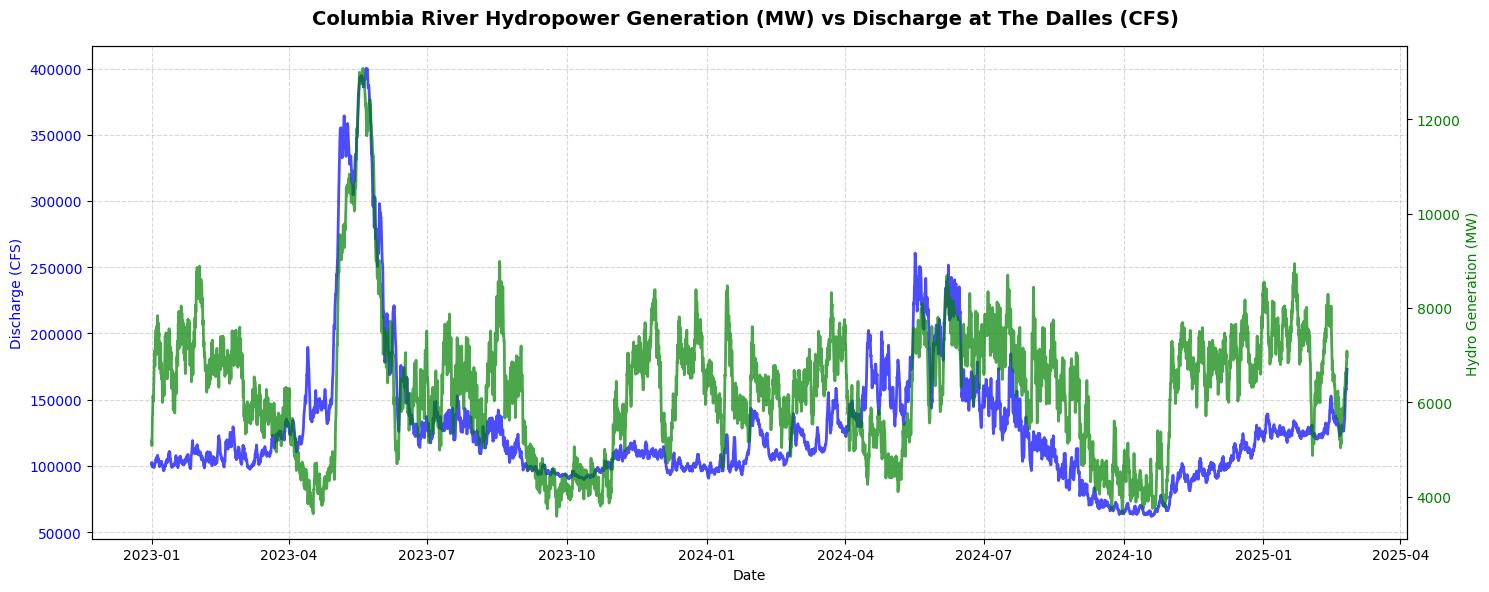

In [3]:
# Compute rolling averages to smooth out fluctuations
discharge = df['Discharge_CFS'].rolling(window=30, min_periods=1).mean()
generation = df['Columbia_Projects_Hydro_Generation_MW'].rolling(window=30, min_periods=1).mean()

# Plot generation and discharge
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Discharge (CFS) on primary y-axis
ax1.set_xlabel("Date")
ax1.set_ylabel("Discharge (CFS)", color="blue")
ax1.plot(df.index, discharge, label="Discharge at The Dalles", color="blue", linewidth=2, alpha=0.7)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True, linestyle="--", alpha=0.5)

# Create secondary y-axis for Hydropower Generation (MW)
ax2 = ax1.twinx()  
ax2.set_ylabel("Hydro Generation (MW)", color="green")
ax2.plot(df.index, generation, label="Hydropower Generation", color="green", linewidth=2, alpha=0.7)
ax2.tick_params(axis="y", labelcolor="green")

fig.suptitle("Columbia River Hydropower Generation (MW) vs Discharge at The Dalles (CFS)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
fig.tight_layout()

plt.show()

## **Columbia River Hydropower Generation vs Discharge at The Dalles - Short Term**

The two subplots visualize the relationship between **Discharge at The Dalles (CFS)** and **Columbia River Hydropower Generation (MW)** for the week of **January 8 - January 15, 2025**.

---

### **Key Observations**
#### **Daily Cycles in Both Discharge & Generation**
- Both discharge and power generation exhibit strong daily fluctuations.
- This is likely due to hydropower dam operations adjusting for peak electricity demand (morning/evening peaks).
- Discharge spikes tend to align with increased power generation, confirming the dependence of hydropower on discharge.

#### **Weekend vs. Weekday Differences**
- There appear to be some variations in discharge and generation across different days (lower generation on the weekends).
- This could be due to changes in energy demand patterns on weekends vs. weekdays, impacting dam operations.

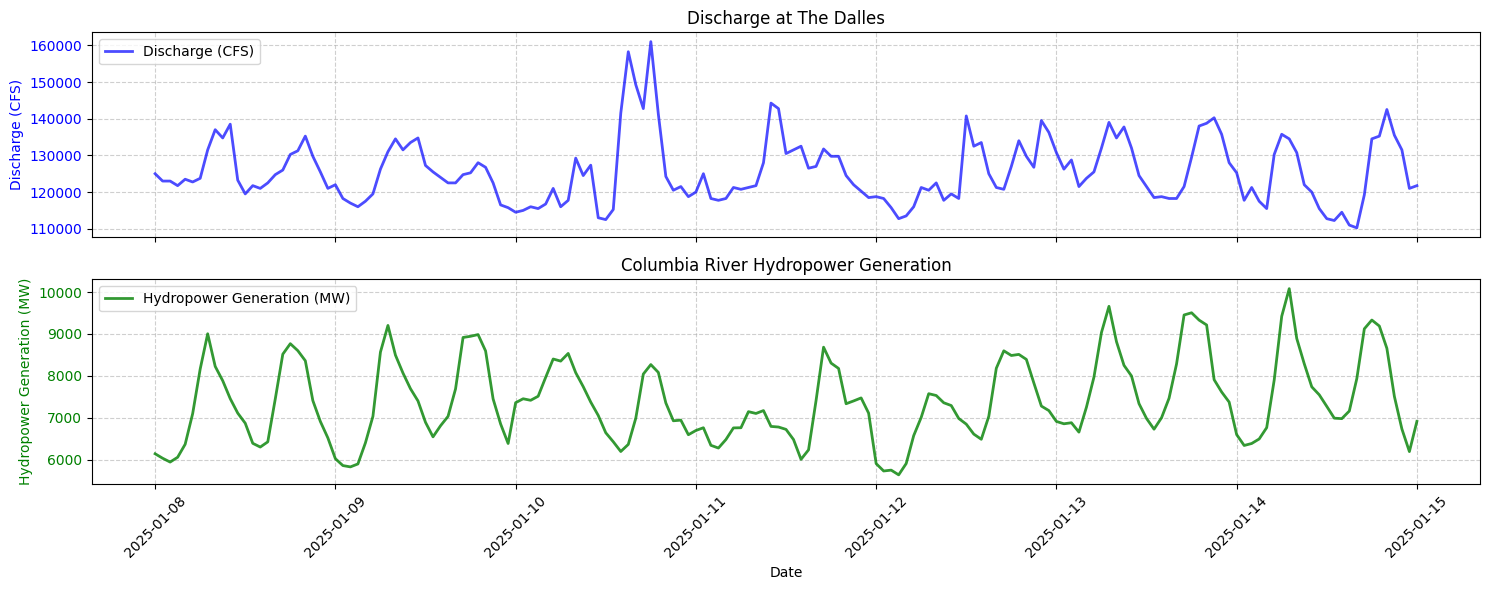

In [4]:
# Filter data for the selected period
df_filtered = df.loc[(df.index >= '2025-01-08') & (df.index <= '2025-01-15')]

# Plot generation and discharge
fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

# Plot Discharge at The Dalles
axes[0].plot(df_filtered.index, df_filtered["Discharge_CFS"], color="blue", alpha=0.7, linewidth=2, label="Discharge (CFS)")
axes[0].set_ylabel("Discharge (CFS)", color="blue")
axes[0].set_title("Discharge at The Dalles")
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend(loc="upper left")
axes[0].tick_params(axis="y", labelcolor="blue")

# Plot Hydropower Generation
axes[1].plot(df_filtered.index, df_filtered["Columbia_Projects_Hydro_Generation_MW"], color="green", alpha=0.8, linewidth=2, label="Hydropower Generation (MW)")
axes[1].set_ylabel("Hydropower Generation (MW)", color="green")
axes[1].set_title("Columbia River Hydropower Generation")
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend(loc="upper left")
axes[1].tick_params(axis="y", labelcolor="green")

plt.xticks(rotation=45)
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()


## **Feature Creation: Adding Seasonality & Lagged Discharge Features**

To improve the forecasting accuracy of our model, we generate seasonality features and lagged discharge features to capture recurring patterns and historical dependencies in hydropower generation.

---

### Adding Seasonality Features
This function extracts **time-based components** from the `Datetime` index because hydropower generation depends on daily usage cycles, weekly demand shifts, and seasonal changes in river flow. These features help the model recognize periodic patterns.

- **Hour** captures daily fluctuations in power generation and discharge.
- **Dayofweek** helps model weekday vs. weekend variations.
- **Month** accounts for seasonal trends in discharge and generation.

### Adding Lagged Discharge Features
This function creates lagged versions of Discharge_CFS at multiple time intervals:

- **Short-term lags (1, 6, 12, 24 hours)** capture immediate trends.
- **Medium-term lags (168 hours = 1 week)** capture weekly trends.
- **Long-term lags (720 hours = 1 month, 2160 hours = 3 months, 8640 hours = 1 year)** capture seasonal trends.

In [5]:
def add_seasonality_feature(df):
    df['Hour'] = df.index.hour
    df['Dayofweek'] = df.index.dayofweek
    df['Month'] = df.index.month
    return df

def add_lagged_discharge_feature(df):
    discharge_map = df["Discharge_CFS"].to_dict()
    for lag in [1, 6, 12, 24, 168, 720, 2160, 8640]:
        df[f"Discharge_Lag_{lag}"] = (df.index - pd.Timedelta(hours=lag)).map(discharge_map)
    return df


In [6]:
df = add_seasonality_feature(df)
df = add_lagged_discharge_feature(df)

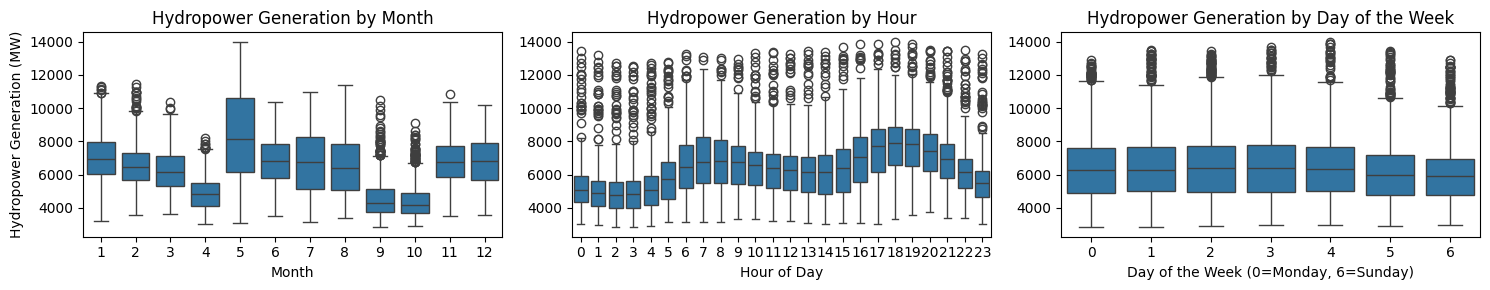

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Boxplot for Month
sns.boxplot(data=df, x='Month', y='Columbia_Projects_Hydro_Generation_MW', ax=axes[0])
axes[0].set_title("Hydropower Generation by Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Hydropower Generation (MW)")

# Boxplot for Hour
sns.boxplot(data=df, x='Hour', y='Columbia_Projects_Hydro_Generation_MW', ax=axes[1])
axes[1].set_title("Hydropower Generation by Hour")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("")

# Boxplot for Day of the Week
sns.boxplot(data=df, x='Dayofweek', y='Columbia_Projects_Hydro_Generation_MW', ax=axes[2])
axes[2].set_title("Hydropower Generation by Day of the Week")
axes[2].set_xlabel("Day of the Week (0=Monday, 6=Sunday)")
axes[2].set_ylabel("")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## **Train-Test Split**
- Defines `FEATURES` including current discharge, lagged discharge values, and seasonal features (`Hour`, `Dayofweek`, `Month`).  
- Splits the data into **80% training and 20% testing** without shuffling, ensuring the model learns from past patterns for time series forecasting.  

In [8]:
# Define features and target
FEATURES = ["Discharge_CFS", "Discharge_Lag_1", "Discharge_Lag_6", "Discharge_Lag_12", "Discharge_Lag_24", "Discharge_Lag_168", "Discharge_Lag_720",
                   "Discharge_Lag_2160", "Discharge_Lag_8640", "Hour", "Dayofweek", "Month"]

X = df[FEATURES]
y = df["Columbia_Projects_Hydro_Generation_MW"]

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

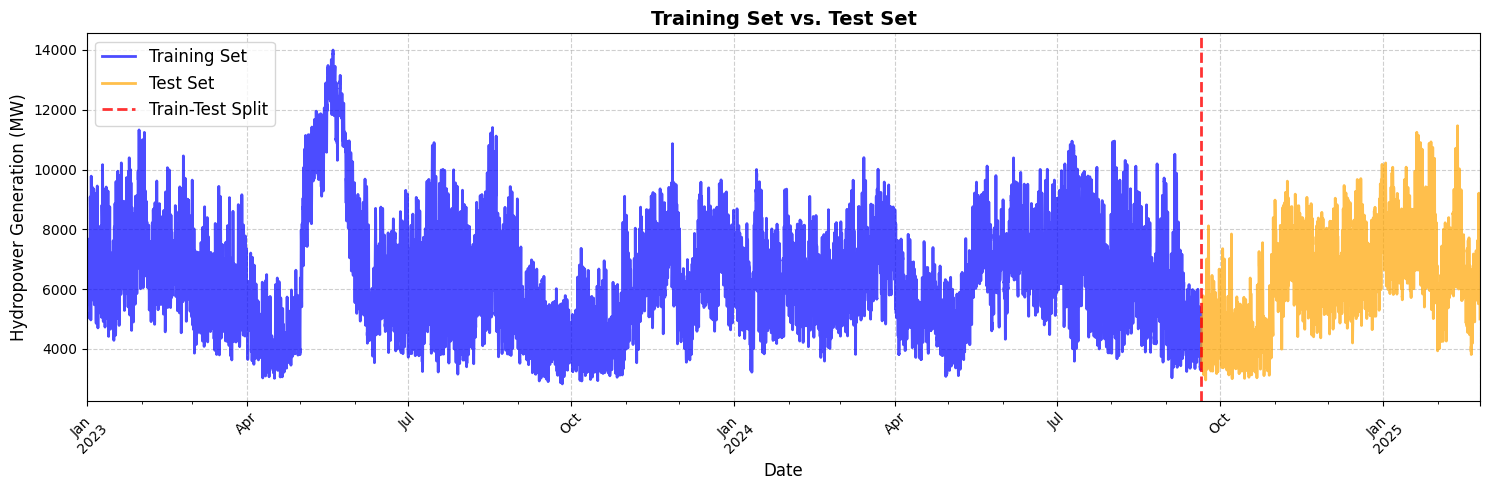

In [9]:
# Plot training and test set
fig, ax = plt.subplots(figsize=(15, 5))

# Plot Training Set
y_train.plot(ax=ax, label="Training Set", color="blue", linewidth=2, alpha=0.7)

# Plot Test Set
y_test.plot(ax=ax, label="Test Set", color="orange", linewidth=2, alpha=0.7)

ax.set_title("Training Set vs. Test Set", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Hydropower Generation (MW)", fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

split_index = y_train.index[-1]  # Last date of training set
ax.axvline(split_index, color="red", linestyle="--", linewidth=2, alpha=0.8, label="Train-Test Split")

ax.legend(loc="upper left", fontsize=12)
fig.tight_layout()

plt.show()

## **Create and Train XGBoost Model**

**XGBoost Regressor** is a powerful gradient boosting algorithm designed for efficient, high-performance regression tasks. It optimizes predictions by combining multiple decision trees, reducing errors iteratively, and handling large datasets with fast training speed and early stopping to prevent overfitting data.


In [24]:
model = xgb.XGBRegressor(n_estimators=500, 
                         early_stopping_rounds=50, 
                         learning_rate=0.01, 
                         objective="reg:squarederror")
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)


[0]	validation_0-rmse:1871.58553	validation_1-rmse:1640.18488
[100]	validation_0-rmse:1156.55968	validation_1-rmse:1212.29187
[200]	validation_0-rmse:881.52929	validation_1-rmse:1054.42657
[300]	validation_0-rmse:737.99586	validation_1-rmse:1014.70192
[400]	validation_0-rmse:675.75482	validation_1-rmse:1002.48824
[499]	validation_0-rmse:638.46910	validation_1-rmse:994.45191


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

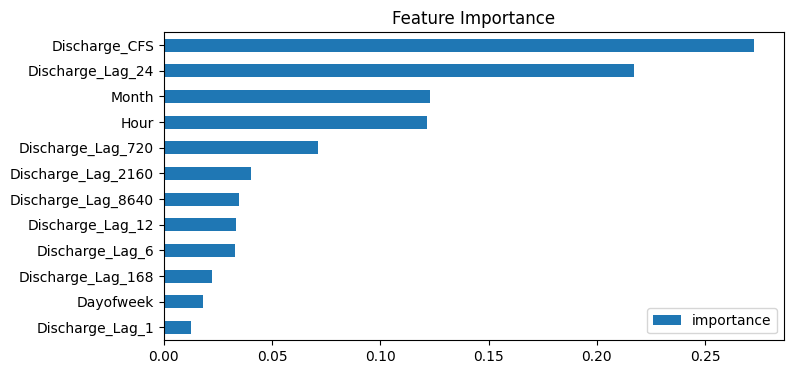

In [11]:
# Plot feature importance for the model
feature_importance = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_, columns=['importance'])
feature_importance.sort_values('importance').plot(figsize=(8,4), kind='barh', title='Feature Importance')

## **Forecast and Error Estimation on Test Data**

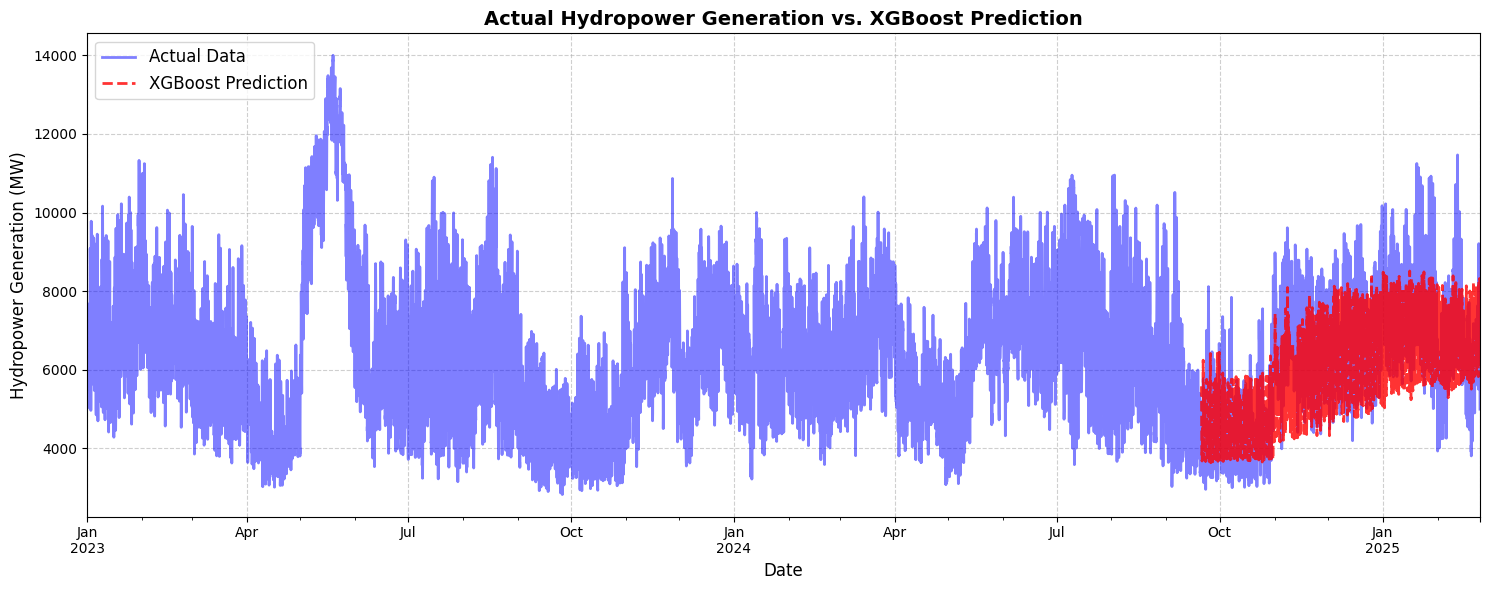

In [12]:
# Predict values using the trained model
y_pred = model.predict(X_test)

# Convert predictions to a DataFrame with the correct index
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['Prediction'])

# Plot actual data and predictions
fig, ax = plt.subplots(figsize=(15, 6))
df['Columbia_Projects_Hydro_Generation_MW'].plot(ax=ax, color="blue", linewidth=2, alpha=0.5, label="Actual Data")
y_pred_df['Prediction'].plot(ax=ax, color="red", linewidth=2, alpha=0.8, linestyle="--", label="XGBoost Prediction")

ax.set_title("Actual Hydropower Generation vs. XGBoost Prediction", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Hydropower Generation (MW)", fontsize=12)

ax.legend(loc="upper left", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


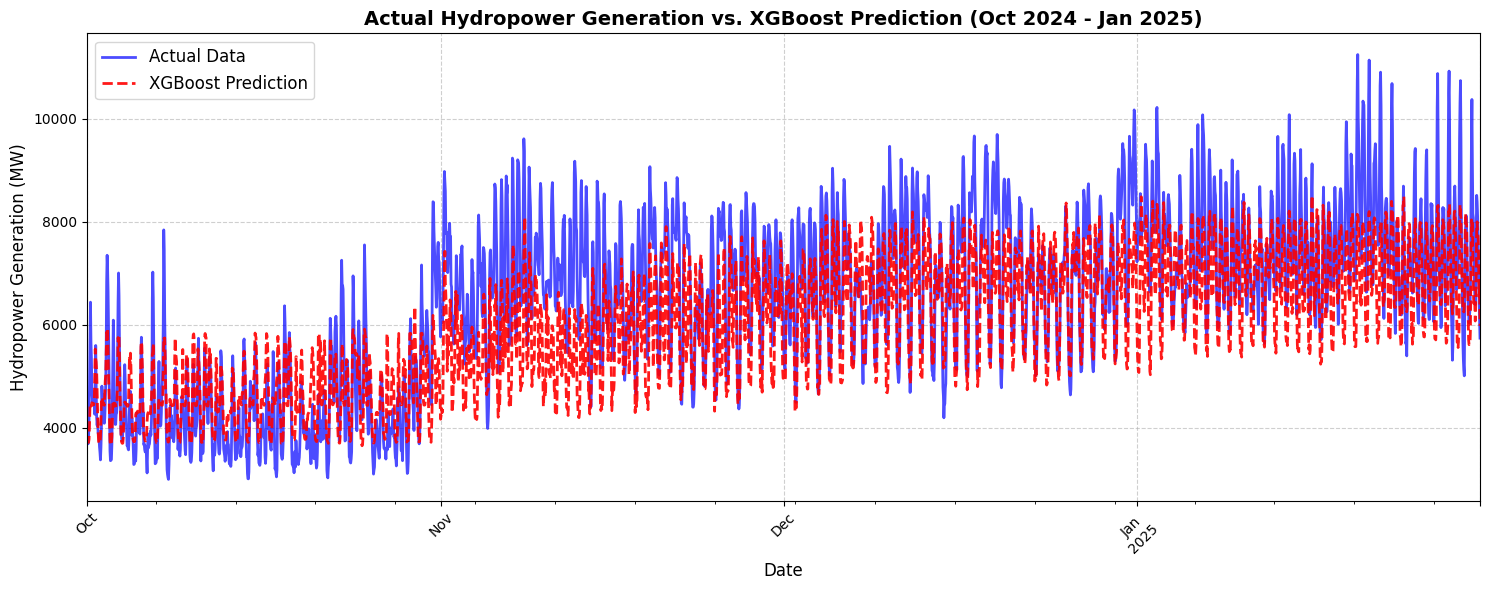

In [13]:
# Define the date range for filtering
start_date = '2024-10-01'
end_date = '2025-01-31'

actual_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'Columbia_Projects_Hydro_Generation_MW']
predicted_data = y_pred_df.loc[(y_pred_df.index >= start_date) & (y_pred_df.index <= end_date), 'Prediction']

# Plot actual data and predictions
fig, ax = plt.subplots(figsize=(15, 6))
actual_data.plot(ax=ax, color="blue", linewidth=2, alpha=0.7, label="Actual Data")
predicted_data.plot(ax=ax, color="red", linewidth=2, linestyle="--", alpha=0.9, label="XGBoost Prediction")

ax.set_title("Actual Hydropower Generation vs. XGBoost Prediction (Oct 2024 - Jan 2025)", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Hydropower Generation (MW)", fontsize=12)

ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="upper left", fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## **Performance Evaluation**

In this section, we evaluate the performance of the XGBoost model using two key error metrics:

- **Root Mean Squared Error (RMSE)**  
   - Measures the average magnitude of prediction errors, giving higher weight to large errors.  
   - Lower RMSE indicates better model performance.

- **Mean Absolute Error (MAE)**  
   - Measures the absolute difference between predicted and actual values.  
   - Unlike RMSE, it treats all errors equally, making it less sensitive to large errors.

Lower RMSE and MAE values indicate that the model's predictions are reasonably accurate. The model outperforms traditional statistical methods like Linear Regression and Vector Autoregression.

In [14]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE Score on the test set: {rmse:0.2f}")
print(f"Mean Absolute Error on the test set: {mae:0.2f}")

RMSE Score on the test set: 994.41
Mean Absolute Error on the test set: 781.99


### **Error Dataframe**

In [15]:
error_df = pd.DataFrame({
    'Test_Data': y_test,
    'Predicted_Data': y_pred_df['Prediction'],
    'Error': np.abs(y_test - y_pred_df['Prediction'])
}, index=y_test.index)
error_df.head(5)

,Test_Data,Predicted_Data,Error
Datetime,,,
2024-09-20 19:00:00,5046.9,5579.781250,532.881250
2024-09-20 20:00:00,4905.3,5312.244629,406.944629
2024-09-20 21:00:00,4932.8,4748.645508,184.154492
2024-09-20 22:00:00,4347.0,4274.593750,72.406250
2024-09-20 23:00:00,4123.9,3941.288818,182.611182


### **Top 5 Dates with the Highest Error**
- These are the dates where the model had the largest prediction deviations from actual values, which maybe due to
  - Sudden fluctuations in discharge
  - Seasonal demand spikes
  - Outliers or unexpected river flow patterns

In [16]:
error_df['Date'] = error_df.index.date
error_df.groupby('Date')['Error'].mean().sort_values(ascending=False).head(5)

Date
2025-02-01    1931.151794
2024-11-12    1870.288529
2025-01-20    1856.637850
2024-11-13    1763.793888
2024-10-31    1709.496676
Name: Error, dtype: float64

### **Top 5 Days with the Lowest Error**

In [17]:
error_df.groupby('Date')['Error'].mean().sort_values(ascending=True).head(5)


Date
2024-12-25    240.966606
2024-10-11    274.415857
2024-09-20    275.799561
2024-12-22    282.168026
2024-09-28    301.832204
Name: Error, dtype: float64

## **Forecast for Next 30 Days**

### Train Model with Historical Data

In [18]:
model.fit(X, y, eval_set=[(X, y)], verbose=100)

[0]	validation_0-rmse:1827.59885
[100]	validation_0-rmse:1146.87836
[200]	validation_0-rmse:887.11463
[300]	validation_0-rmse:753.93423
[400]	validation_0-rmse:695.13844
[499]	validation_0-rmse:662.03998


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Future Dates Data Preparation

In [26]:
# Applying seasonality and discharge lag features to the future dates 
future = pd.date_range(start=df.index.max(), periods=720, freq='h') 
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = add_seasonality_feature(df_and_future)
df_and_future = add_lagged_discharge_feature(df_and_future)
future_with_features = df_and_future.query('isFuture').copy()

### Prediction

In [20]:
# Predict based on lagged discharge and seasonality features
future_with_features['Prediction'] = model.predict(future_with_features[FEATURES])

### Hourly Forecast for Next 30 Days

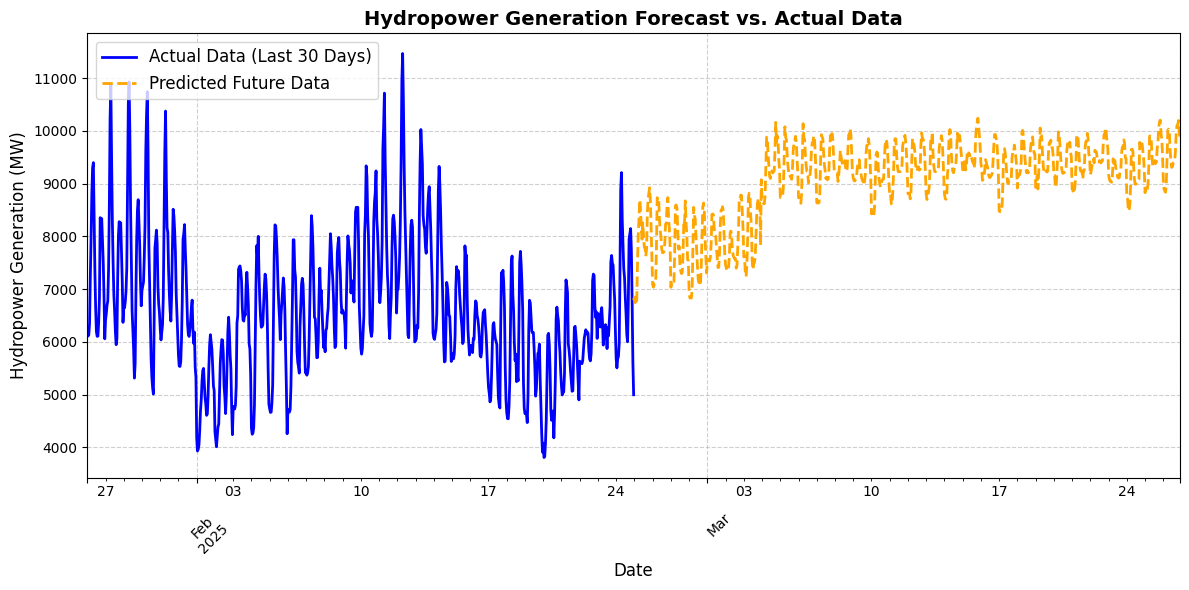

In [21]:
# Plot hourly predictions vs actual data
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual past data
df['Columbia_Projects_Hydro_Generation_MW'][-720:].plot(ax=ax, color="blue", linewidth=2, label="Actual Data (Last 30 Days)")

# Plot forecasted future values
future_with_features['Prediction'].plot(ax=ax, color="orange", linewidth=2, linestyle="--", label="Predicted Future Data")

ax.set_title("Hydropower Generation Forecast vs. Actual Data", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Hydropower Generation (MW)", fontsize=12)

ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="upper left", fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Daily Forecast for Next 30 Days

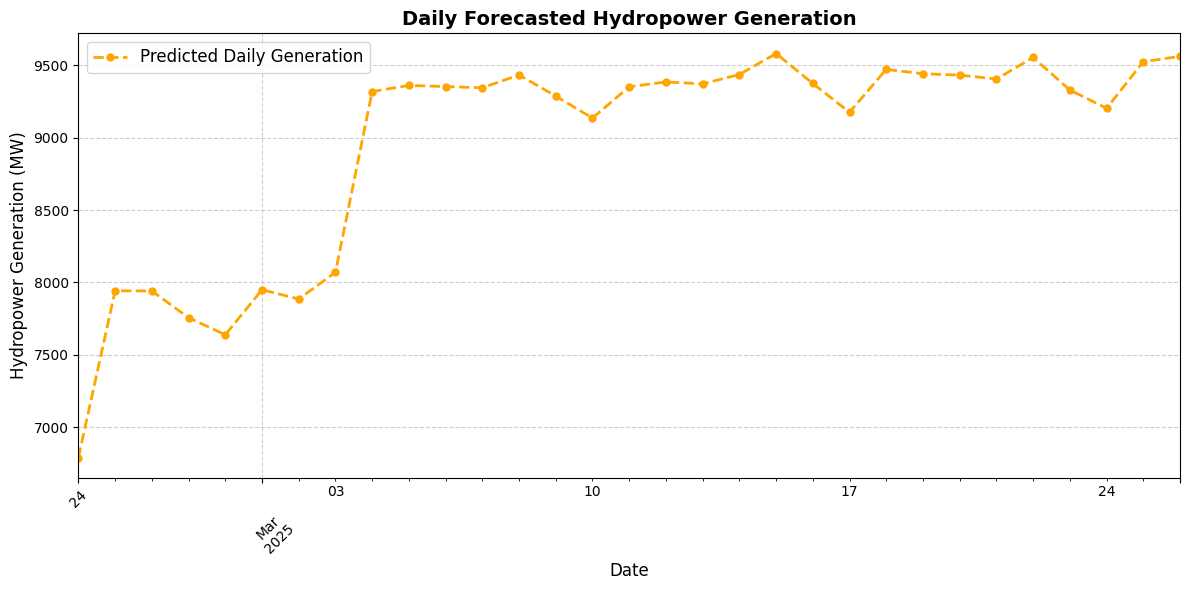

In [22]:
# Resample predictions to daily values
daily_forecast = future_with_features['Prediction'].resample('D').mean()

# Plot daily forecast
fig, ax = plt.subplots(figsize=(12, 6))

# Plot daily aggregated forecast
daily_forecast.plot(ax=ax, color="orange", linewidth=2, linestyle="--", marker='o', markersize=5, label="Predicted Daily Generation")

ax.set_title("Daily Forecasted Hydropower Generation", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Hydropower Generation (MW)", fontsize=12)

ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="upper left", fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Conclusion**

The forecasted hydropower generation (orange dashed line) follows the observed discharge and seasonal trends used in training the model. The predictions exhibit variability, capturing changes in past water flow and daily and monthly seasonal trends.

### **Model Considerations & Potential Improvements**
- **Enhancing features**: Model captures variations well, but additional factors (e.g. reservoir management decisions, discharge data from other projects, etc.) could improve long-term accuracy, and more seasonal variables (e.g., temperature, snowmelt, precipitation, etc.) could enhance forecasting during seasonal transitions
- **Finetuning Hyperparameters**: Further optimization of model hyperparameters could improve XGBoost performance.  
- **Noise Reduction**: Applying **smoother transformations** or feature engineering techniques (e.g., rolling averages, Fourier transforms) could enhance prediction stability.  
- **Testing More Complex Models**: Testing models like **LSTM (Long Short-Term Memory Networks)** which are designed for sequential time-series data and could capture long-term dependencies in hydropower generation patterns.  

This forecast provides a data-driven estimate of future generation trends, allowing for better planning and grid management. Further refinements and exploration of advanced time-series models could significantly enhance accuracy and robustness